In [1]:
pip install meteostat

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install fuzzywuzzy[speedup] pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from meteostat import Point, Daily
import pandas as pd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
import folium
from folium import Marker
from folium.plugins import HeatMap
from fuzzywuzzy import process
import numpy as np
import seaborn as sns

In [4]:
# Read CSV file
uni_data = pd.read_csv('merged_datasets.csv')
uni_data.head(50)

,University Name,In State Tuition,Out of State Tuition,Admission Rate,Number of Students,Graduation Rate 4-years,Earnings After 10 Years,Retention Rate,Diversity Score,Public or Private,...,er score,isr score,fsr score,ifr score,Acres,University ID,Safety,Facilities,Social,Average Sentiment
0,Boston College,22144,22144,0.1670,259,0.4545,62123,0.8235,0.597781,0,...,12.9,18.3,19.3,12.0,240.0,37,4.7,4.3,3.8,0.596994
1,Boston University,62360,62360,0.1437,17668,0.8916,83238,0.9397,0.671706,0,...,68.3,87.5,32.7,21.6,140.0,41,4.2,3.7,3.7,0.376901
2,Brown University,29720,29720,0.5664,1354,0.7078,53907,0.8445,0.431634,0,...,42.4,52.0,77.8,84.5,146.0,13,4.5,4.4,4.5,0.694265
3,California Institute of Technology,19190,19190,0.0270,540,0.7828,53598,0.9474,0.483280,0,...,93.7,81.0,100.0,100.0,124.0,6,4.2,4.3,3.6,0.458000
4,Carnegie Mellon University,61344,61344,0.1130,7005,0.9214,114862,0.9730,0.673670,0,...,75.3,98.2,49.1,46.6,150.0,21,4.3,4.0,3.2,0.324381
5,Columbia University,66139,66139,0.0395,8902,0.9528,102491,0.9792,0.679876,0,...,98.3,96.8,100.0,56.1,36.0,14,3.5,3.9,3.3,0.356867
6,Cornell University,63200,63200,0.0790,16071,0.8800,104043,0.9600,0.661828,0,...,90.5,64.0,52.9,68.7,2300.0,11,4.4,4.6,4.0,0.553095
7,Dartmouth College,62658,62658,0.0638,4412,0.9448,97434,0.9803,0.644170,0,...,24.2,33.9,57.9,5.3,269.0,15,4.2,4.5,4.1,0.651600
8,Duke University,62688,62688,0.0635,6570,0.9625,97800,0.9685,0.700444,0,...,69.3,52.2,100.0,16.8,8693.0,7,4.4,4.8,4.4,0.729300
9,Emory University,57948,57948,0.1135,7017,0.9002,80137,0.9521,0.706744,0,...,16.4,31.1,97.7,37.3,600.0,24,4.7,4.6,3.7,0.565966


In [5]:
standard_names = ['Princeton University',
 'Massachusetts Institute of Technology',
 'Harvard University',
 'Stanford University',
 'Yale University',
 'California Institute of Technology',
 'Duke University',
 'Johns Hopkins University',
 'Northwestern University',
 'University of Pennsylvania',
 'Cornell University',
 'University of Chicago',
 'Brown University',
 'Columbia University',
 'Dartmouth College',
 'University of California, Los Angeles',
 'University of California, Berkeley',
 'Rice University',
 'University of Notre Dame',
 'Vanderbilt University',
 'Carnegie Mellon University',
 'University of Michigan, Ann Arbor',
 'Washington University in St. Louis',
 'Emory University',
 'Georgetown University',
 'University of Virginia',
 'University of North Carolina, Chapel Hill',
 'University of Southern California',
 'University of California, San Diego',
 'New York University',
 'University of Florida',
 'University of Texas, Austin',
 'Georgia Institute of Technology',
 'University of California, Davis',
 'University of California, Irvine',
 'University of Illinois, Urbana-Champaign',
 'Boston College',
 'Tufts University',
 'University of California, Santa Barbara',
 'University of Wisconsin, Madison',
 'Boston University',
 'Ohio State University, Columbus',
 'Rutgers University, New Brunswick',
 'University of Maryland, College Park',
 'University of Rochester',
 'Lehigh University',
 'Purdue University',
 'University of Georgia',
 'University of Washington',
 'Wake Forest University']

In [6]:
def standardize_column_values(df, column, standard_names, threshold=80):

    updated_values = []
    
    for value in df[column]:
        match, score = process.extractOne(value, standard_names)
        if score >= threshold:
            updated_values.append(match)  # Use the matched standard name
        else:
            updated_values.append(value)  # Keep the original name if no good match
    
    df[column] = updated_values
    return df

In [7]:
uni_data = standardize_column_values(uni_data, 'University Name', standard_names, threshold=80)

In [8]:
uni_data.head(50)

,University Name,In State Tuition,Out of State Tuition,Admission Rate,Number of Students,Graduation Rate 4-years,Earnings After 10 Years,Retention Rate,Diversity Score,Public or Private,...,er score,isr score,fsr score,ifr score,Acres,University ID,Safety,Facilities,Social,Average Sentiment
0,Boston College,22144,22144,0.1670,259,0.4545,62123,0.8235,0.597781,0,...,12.9,18.3,19.3,12.0,240.0,37,4.7,4.3,3.8,0.596994
1,Boston University,62360,62360,0.1437,17668,0.8916,83238,0.9397,0.671706,0,...,68.3,87.5,32.7,21.6,140.0,41,4.2,3.7,3.7,0.376901
2,Brown University,29720,29720,0.5664,1354,0.7078,53907,0.8445,0.431634,0,...,42.4,52.0,77.8,84.5,146.0,13,4.5,4.4,4.5,0.694265
3,California Institute of Technology,19190,19190,0.0270,540,0.7828,53598,0.9474,0.483280,0,...,93.7,81.0,100.0,100.0,124.0,6,4.2,4.3,3.6,0.458000
4,Carnegie Mellon University,61344,61344,0.1130,7005,0.9214,114862,0.9730,0.673670,0,...,75.3,98.2,49.1,46.6,150.0,21,4.3,4.0,3.2,0.324381
5,Columbia University,66139,66139,0.0395,8902,0.9528,102491,0.9792,0.679876,0,...,98.3,96.8,100.0,56.1,36.0,14,3.5,3.9,3.3,0.356867
6,Cornell University,63200,63200,0.0790,16071,0.8800,104043,0.9600,0.661828,0,...,90.5,64.0,52.9,68.7,2300.0,11,4.4,4.6,4.0,0.553095
7,Dartmouth College,62658,62658,0.0638,4412,0.9448,97434,0.9803,0.644170,0,...,24.2,33.9,57.9,5.3,269.0,15,4.2,4.5,4.1,0.651600
8,Duke University,62688,62688,0.0635,6570,0.9625,97800,0.9685,0.700444,0,...,69.3,52.2,100.0,16.8,8693.0,7,4.4,4.8,4.4,0.729300
9,Emory University,57948,57948,0.1135,7017,0.9002,80137,0.9521,0.706744,0,...,16.4,31.1,97.7,37.3,600.0,24,4.7,4.6,3.7,0.565966


In [9]:
def find_coordinates(location_name):
    """
    Finds the latitude and longitude of the location (str)
    """
    geolocator = Nominatim(user_agent="geo_locator")
    try:
        location = geolocator.geocode(location_name)
        return location.latitude, location.longitude
    except GeocoderTimedOut:
        time.sleep(1) 
        return find_coordinates(location_name)

In [10]:
# Apply function to find coordinates and add new columns
uni_data[['Latitude', 'Longitude']] = uni_data['University Name'].apply(lambda name: pd.Series(find_coordinates(name)))

In [11]:
uni_data.head(50)

,University Name,In State Tuition,Out of State Tuition,Admission Rate,Number of Students,Graduation Rate 4-years,Earnings After 10 Years,Retention Rate,Diversity Score,Public or Private,...,fsr score,ifr score,Acres,University ID,Safety,Facilities,Social,Average Sentiment,Latitude,Longitude
0,Boston College,22144,22144,0.1670,259,0.4545,62123,0.8235,0.597781,0,...,19.3,12.0,240.0,37,4.7,4.3,3.8,0.596994,42.335448,-71.168266
1,Boston University,62360,62360,0.1437,17668,0.8916,83238,0.9397,0.671706,0,...,32.7,21.6,140.0,41,4.2,3.7,3.7,0.376901,42.350421,-71.103228
2,Brown University,29720,29720,0.5664,1354,0.7078,53907,0.8445,0.431634,0,...,77.8,84.5,146.0,13,4.5,4.4,4.5,0.694265,41.818640,-71.408801
3,California Institute of Technology,19190,19190,0.0270,540,0.7828,53598,0.9474,0.483280,0,...,100.0,100.0,124.0,6,4.2,4.3,3.6,0.458000,34.137014,-118.125288
4,Carnegie Mellon University,61344,61344,0.1130,7005,0.9214,114862,0.9730,0.673670,0,...,49.1,46.6,150.0,21,4.3,4.0,3.2,0.324381,40.444190,-79.942719
5,Columbia University,66139,66139,0.0395,8902,0.9528,102491,0.9792,0.679876,0,...,100.0,56.1,36.0,14,3.5,3.9,3.3,0.356867,40.807756,-73.961614
6,Cornell University,63200,63200,0.0790,16071,0.8800,104043,0.9600,0.661828,0,...,52.9,68.7,2300.0,11,4.4,4.6,4.0,0.553095,42.452908,-76.480084
7,Dartmouth College,62658,62658,0.0638,4412,0.9448,97434,0.9803,0.644170,0,...,57.9,5.3,269.0,15,4.2,4.5,4.1,0.651600,43.704676,-72.294209
8,Duke University,62688,62688,0.0635,6570,0.9625,97800,0.9685,0.700444,0,...,100.0,16.8,8693.0,7,4.4,4.8,4.4,0.729300,36.000156,-78.944230
9,Emory University,57948,57948,0.1135,7017,0.9002,80137,0.9521,0.706744,0,...,97.7,37.3,600.0,24,4.7,4.6,3.7,0.565966,33.800455,-84.317238


In [12]:
# Create a map of North America 
map_na = folium.Map(location=[39.8283, -98.5795], tiles='cartodbpositron', zoom_start=4)

# Add universities to the map based on location
for idx, row in uni_data.iterrows():
    folium.Marker(location=[row["Latitude"], row["Longitude"]],popup=f"{row['University Name']}").add_to(map_na)

# Display Map
map_na

In [13]:
# Creating a function that creates heatmaps
def create_heatmap(dataframe, column):

    # Initialize a map of North America
    heatmap = folium.Map(location=[39.8283, -98.5795], tiles='cartodbpositron', zoom_start=4)
    
    # Viridis color scale
    viridis_gradient = {
        0.0: '#440154',  # Dark purple
        0.2: '#3b528b',  # Blue
        0.4: '#21908d',  # Teal
        0.6: '#5ec962',  # Green
        0.8: '#fde725',  # Yellow
        1.0: '#ffffbf'   # Light yellow
    }
    
    # Extract Data & Create Layer
    heatmap_data = list(zip(dataframe["Latitude"], dataframe["Longitude"], dataframe[column]))
    HeatMap(data=heatmap_data, radius=20, gradient=viridis_gradient).add_to(heatmap)
    
    return heatmap

In [14]:
# Create heatmaps for in-state and out-of-state tuition
heatmap_academic_reputation = create_heatmap(uni_data, "ar score")
heatmap_employee_reputation = create_heatmap(uni_data, "er score")

In [15]:
# Display heatmaps for academic reputation
heatmap_academic_reputation

In [16]:
# Display heatmaps for employee reputation
heatmap_employee_reputation

In [17]:
# Splitting data into private and public
private_universities = uni_data[uni_data["Public or Private"] == 0]
public_universities = uni_data[uni_data["Public or Private"] == 1]

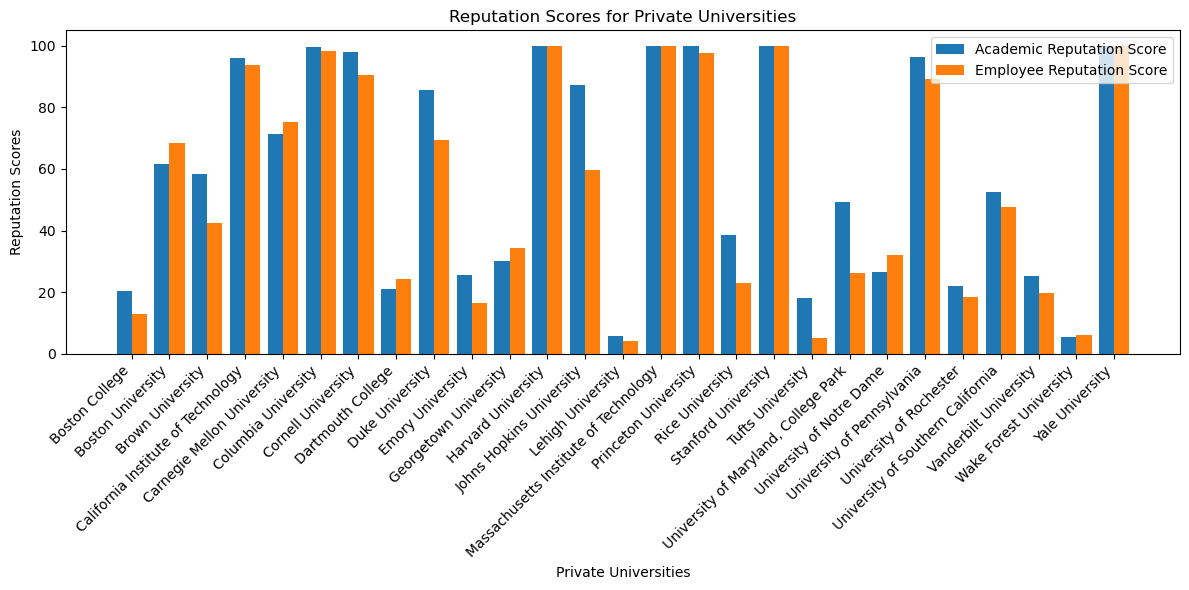

In [18]:
# Plot double bar graph for private universities that shows reputation scores (Academic Reputation Score & Employee Reputation Score)
plt.figure(figsize=(12, 6))
x_private = range(len(private_universities["University Name"]))
plt.bar(x_private, private_universities["ar score"], width=0.4, label="Academic Reputation Score", align='center')
plt.bar([i + 0.4 for i in x_private], private_universities["er score"], width=0.4, label="Employee Reputation Score", align='center')
plt.xticks([i + 0.2 for i in x_private], private_universities["University Name"], rotation=45, ha='right')
plt.xlabel("Private Universities")
plt.ylabel("Reputation Scores")
plt.title("Reputation Scores for Private Universities")
plt.legend()
plt.tight_layout()
plt.show()

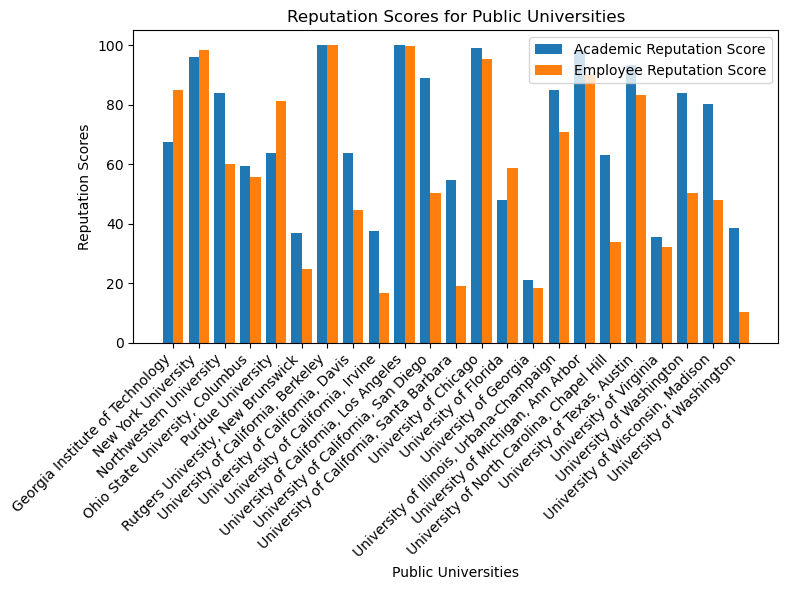

In [19]:
# Plot double bar graph for public universities that shows reputation scores (Academic Reputation Score & Employee Reputation Score)
plt.figure(figsize=(8, 6))
x_public = range(len(public_universities["University Name"]))
plt.bar(x_public, public_universities["ar score"], width=0.4, label="Academic Reputation Score", align='center')
plt.bar([i + 0.4 for i in x_public], public_universities["er score"], width=0.4, label="Employee Reputation Score", align='center')
plt.xticks([i + 0.2 for i in x_public], public_universities["University Name"], rotation=45, ha='right')
plt.xlabel("Public Universities")
plt.ylabel("Reputation Scores")
plt.title("Reputation Scores for Public Universities")
plt.legend()
plt.tight_layout()
plt.show()

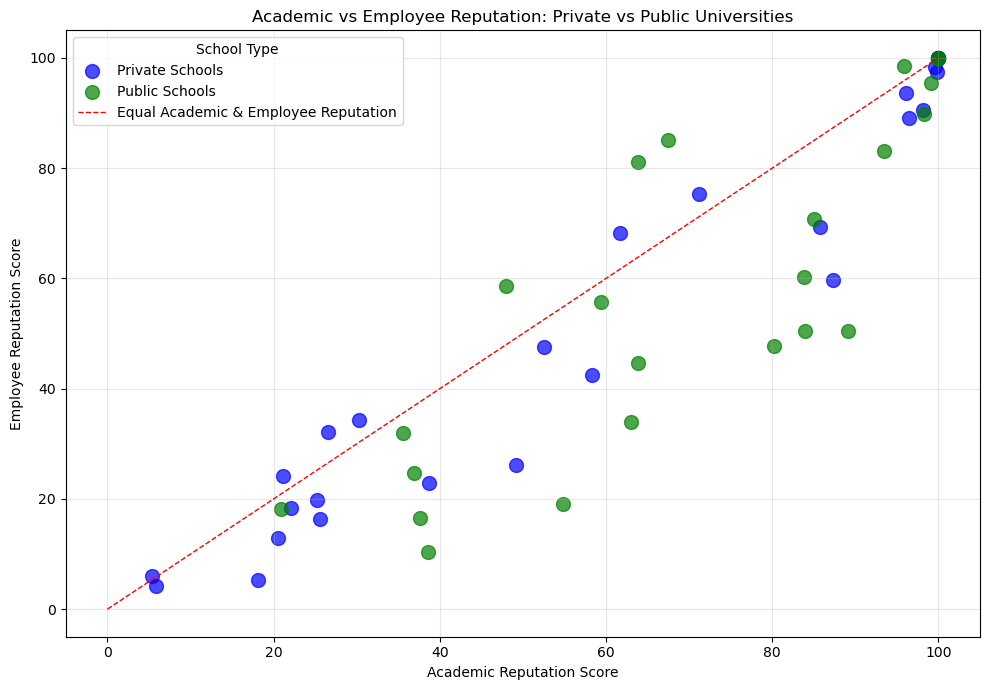

In [20]:
# Separate private and public universities
private_uni_data = uni_data[uni_data["Public or Private"] == 0]
public_uni_data = uni_data[uni_data["Public or Private"] == 1]

# Plot Academic Reputation Scores vs. Employee Reputation Scores
plt.figure(figsize=(10, 7))
plt.scatter(private_uni_data["ar score"], private_uni_data["er score"], color='blue', label='Private Schools', alpha=0.7, s=100)
plt.scatter(public_uni_data["ar score"], public_uni_data["er score"],color='green', label='Public Schools', alpha=0.7, s=100)
plt.plot([0, 100], [0, 100], color='red', linestyle='--', linewidth=1, label='Equal Academic & Employee Reputation')
plt.xlabel("Academic Reputation Score")
plt.ylabel("Employee Reputation Score")
plt.title("Academic vs Employee Reputation: Private vs Public Universities")
plt.legend(title="School Type")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

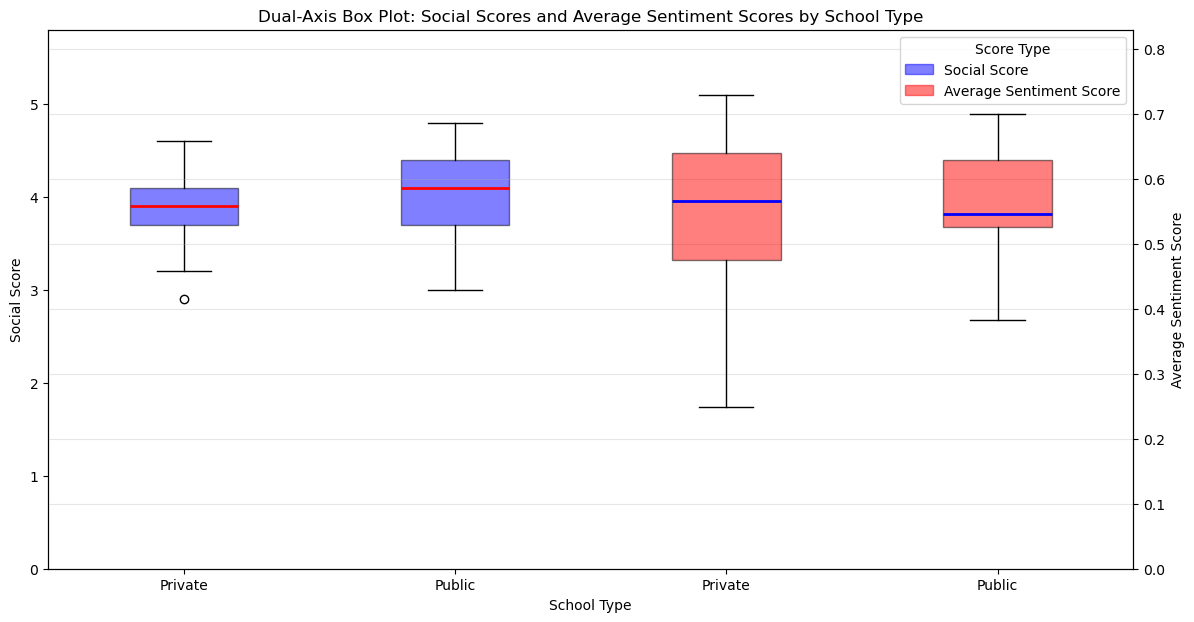

In [21]:
# Creating a dual-axis box plot of Social Scores & Average Sentiment Scores
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.boxplot([private_uni_data["Social"], public_uni_data["Social"]],positions=[1, 2], widths=0.4, patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.5), medianprops=dict(color='red', linewidth=2))
ax1.set_ylabel("Social Score")
ax1.set_ylim(0, max(uni_data["Social"]) + 1)
ax2 = ax1.twinx()
ax2.boxplot([private_uni_data["Average Sentiment"], public_uni_data["Average Sentiment"]], positions=[3, 4], widths=0.4, patch_artist=True, boxprops=dict(facecolor='red', alpha=0.5), medianprops=dict(color='blue', linewidth=2))
ax2.set_ylabel("Average Sentiment Score")
ax2.set_ylim(0, max(uni_data["Average Sentiment"]) + 0.1)
plt.xticks([1, 2, 3, 4], ["Private", "Public", "Private", "Public"])
ax1.set_title("Dual-Axis Box Plot: Social Scores and Average Sentiment Scores by School Type")
ax1.set_xlabel("School Type")
plt.grid(alpha=0.3)
blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='Social Score')
red_patch = mpatches.Patch(color='red', alpha=0.5, label='Average Sentiment Score')
plt.legend(handles=[blue_patch, red_patch], title="Score Type", loc="upper right")
plt.show()

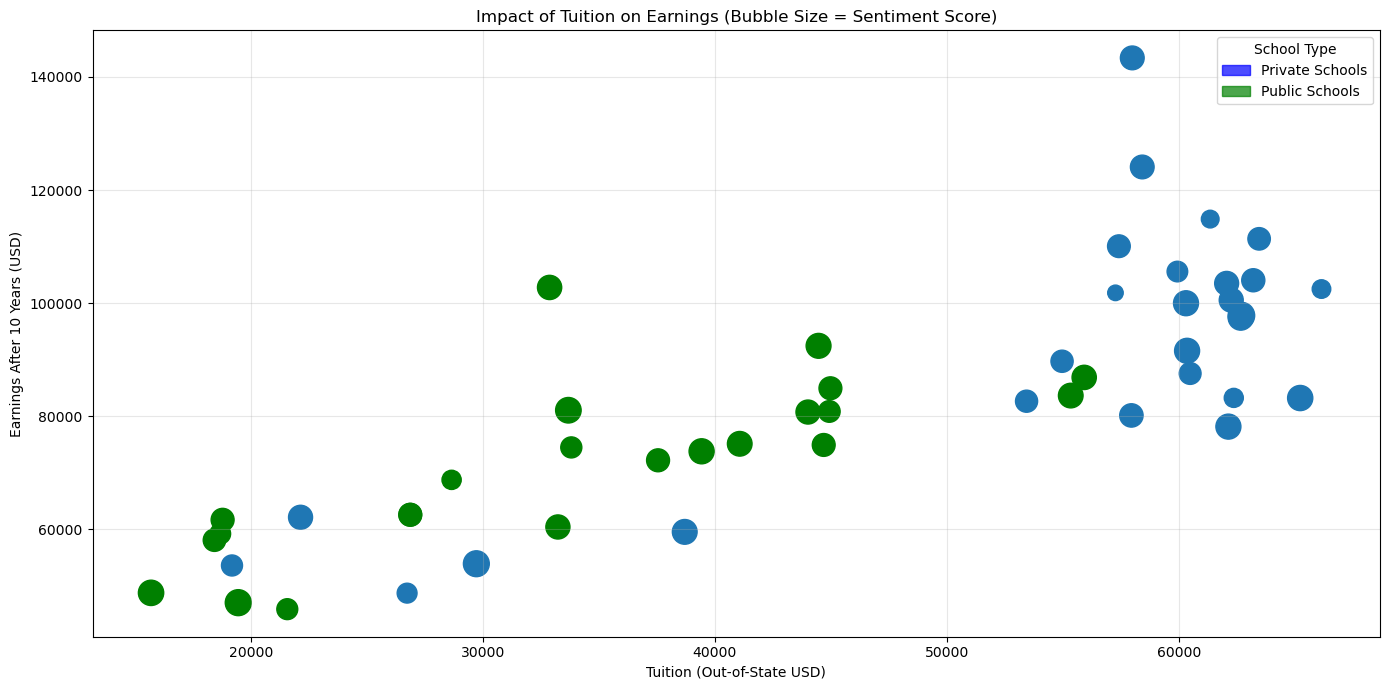

In [22]:
# Creating a bubble chart of Tuition vs Earnings with bubble size representing sentiment score
plt.figure(figsize=(14, 7))
plt.scatter(private_uni_data["Out of State Tuition"], private_uni_data["Earnings After 10 Years"],s=private_uni_data["Average Sentiment"] * 500)  # Scale sentiment score for bubble sizecolor='blue', alpha=0.7, label='Private Schools')
plt.scatter(public_uni_data["Out of State Tuition"], public_uni_data["Earnings After 10 Years"],s=public_uni_data["Average Sentiment"] * 500, color='green')  # Scale sentiment score for bubble sizecolor='green', alpha=0.7, label='Public Schools')
plt.xlabel("Tuition (Out-of-State USD)")
plt.ylabel("Earnings After 10 Years (USD)")
plt.title("Impact of Tuition on Earnings (Bubble Size = Sentiment Score)")
blue_patch = mpatches.Patch(color='blue', alpha=0.7, label='Private Schools')
green_patch = mpatches.Patch(color='green', alpha=0.7, label='Public Schools')
plt.legend(handles=[blue_patch, green_patch], title="School Type", loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

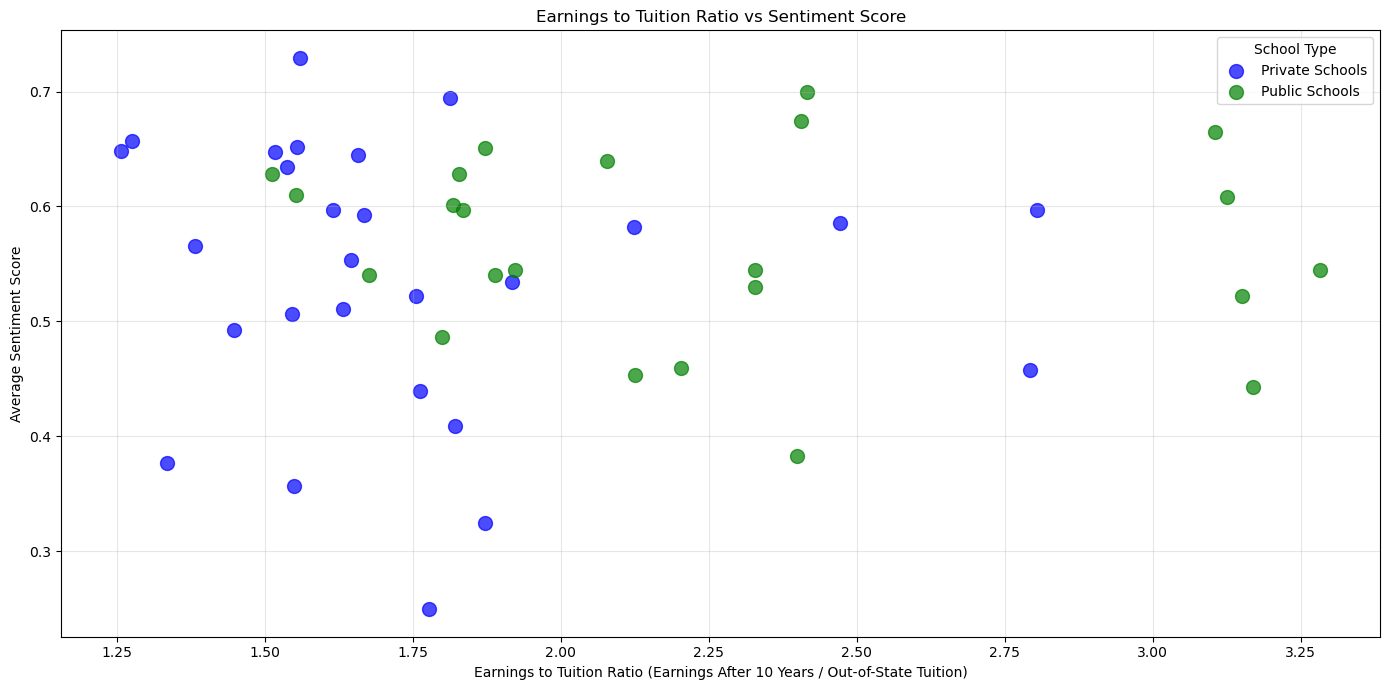

In [23]:
# Calculate the ratio of earnings after 10 years to out-of-state tuition
uni_data["Earnings to Tuition Ratio"] = uni_data["Earnings After 10 Years"] / uni_data["Out of State Tuition"]

# Separate private and public universities
private_uni_data = uni_data[uni_data["Public or Private"] == 0]
public_uni_data = uni_data[uni_data["Public or Private"] == 1]

# Plot
plt.figure(figsize=(14, 7))
plt.scatter(private_uni_data["Earnings to Tuition Ratio"], private_uni_data["Average Sentiment"],color='blue', alpha=0.7, s=100, label="Private Schools")
plt.scatter(public_uni_data["Earnings to Tuition Ratio"], public_uni_data["Average Sentiment"],color='green', alpha=0.7, s=100, label="Public Schools")
plt.xlabel("Earnings to Tuition Ratio (Earnings After 10 Years / Out-of-State Tuition)")
plt.ylabel("Average Sentiment Score")
plt.title("Earnings to Tuition Ratio vs Sentiment Score")
plt.legend(title="School Type")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()